In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

# --- 配置区 ---
# 请确保此文件夹路径与您保存npz文件的位置一致
DATASET_FOLDER = '../datasets'

# 定义一个字典，将特征名称映射到传感器数据中的列索引
# 这使得代码更具可读性和可维护性
SENSOR_COLUMN_MAP = {
    'time_s': 0,
    'Ecell_V': 1,
    'I_mA': 2,
    'EnergyCharge_W_h': 3,
    'QCharge_mA_h': 4,
    'EnergyDischarge_W_h': 5,
    'QDischarge_mA_h': 6,
    'Temperature__C': 7
}

# --- 核心功能函数 ---

def extract_features_from_all_npz(dataset_folder):
    """
    加载所有npz文件，并为每个循环提取/计算关键特征。
    """
    npz_files = [f for f in os.listdir(dataset_folder) if f.endswith('.npz')]
    if not npz_files:
        print(f"在文件夹 '{dataset_folder}' 中没有找到任何 .npz 文件。")
        return None

    all_features_list = []
    print(f"发现 {len(npz_files)} 个 .npz 文件，开始提取特征...")

    for filename in sorted(npz_files):
        file_path = os.path.join(dataset_folder, filename)
        try:
            data_archive = np.load(file_path, allow_pickle=True)
            all_missions_data = data_archive['missions']
            
            for mission in all_missions_data:
                sensor_data = mission['sensor_data']
                capacity = mission['capacity']
                
                if sensor_data.shape[0] == 0: continue # 跳过空循环
                
                # 提取电流和温度列
                current_mA = sensor_data[:, SENSOR_COLUMN_MAP['I_mA']]
                temperature_C = sensor_data[:, SENSOR_COLUMN_MAP['Temperature__C']]
                q_discharge_mAh = sensor_data[:, SENSOR_COLUMN_MAP['QDischarge_mA_h']]

                # 计算特征 (并进行单位转换)
                features = {
                    'Cycle Life': capacity, # 在我们的语境中，每个循环的容量就是SOH的代理
                    'Max Temperature [K]': temperature_C.max() + 273.15,
                    'Mean Temperature [K]': temperature_C.mean() + 273.15,
                    'Max DOD [mAh]': q_discharge_mAh.max(),
                    'Max Current [A]': current_mA.min() / 1000, # 最大放电电流 (负值最大)
                    'Min Current [A]': current_mA.max() / 1000  # 最大充电电流 (正值最大)
                }
                all_features_list.append(features)

        except Exception as e:
            print(f"处理文件 {filename} 时出错: {e}")
            
    return pd.DataFrame(all_features_list)


def plot_correlation_matrix(df, columns):
    """
    创建一个模仿示例图的、高级的成对关系图。
    """
    print("正在计算相关性并生成图表...")
    
    # 计算皮尔逊相关系数矩阵
    corr_matrix = df[columns].corr(method='pearson')
    
    num_vars = len(columns)
    fig, axes = plt.subplots(num_vars, num_vars, figsize=(12, 12))
    
    # 调整子图间距
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for ax in axes.flat:
        ax.set_anchor('N') # 修复可能的对齐问题

    for i, row_var in enumerate(columns):
        for j, col_var in enumerate(columns):
            ax = axes[i, j]
            
            # 关闭所有轴的刻度标签
            if i < num_vars - 1: ax.set_xticklabels([])
            if j > 0: ax.set_yticklabels([])

            # --- 对角线: 绘制直方图 ---
            if i == j:
                sns.histplot(df[row_var], ax=ax, bins=15, kde=False)

            # --- 上三角: 绘制散点图 ---
            elif i < j:
                sns.scatterplot(x=df[col_var], y=df[row_var], ax=ax, s=15, alpha=0.6, edgecolor=None)

            # --- 下三角: 绘制相关性圆圈和数值 ---
            else:
                corr_val = corr_matrix.loc[row_var, col_var]
                
                # 关闭坐标轴
                ax.set_axis_off()
                
                # 创建圆圈
                circle = Circle((0.5, 0.5), radius=0.4 * abs(corr_val)**0.5, facecolor=plt.cm.viridis(0.1 + 0.8*abs(corr_val)), alpha=0.8)
                ax.add_patch(circle)
                
                # 添加文本
                font_color = 'white' if abs(corr_val) > 0.6 else 'black'
                ax.text(0.5, 0.5, f'ρ = {corr_val:.3f}', ha='center', va='center', fontsize=12, color=font_color)

            # 设置X轴和Y轴的标签
            if j == 0 and i > 0: ax.set_ylabel(row_var, rotation=0, ha='right', va='center', fontsize=12)
            if i == num_vars - 1 and j < num_vars-1: ax.set_xlabel(col_var, rotation=30, ha='right', fontsize=12)

    # 在最外层设置标签
    axes[0, 0].set_ylabel(columns[0], rotation=0, ha='right', va='center', fontsize=12)
    axes[num_vars - 1, num_vars - 1].set_xlabel(columns[-1], rotation=30, ha='right', fontsize=12)
    
    plt.suptitle('特征相关性分析矩阵', fontsize=20, y=0.95)
    output_filename = 'features_correlation_matrix.png'
    plt.savefig(output_filename, bbox_inches='tight')
    print(f"\n相关性分析图表已保存为: {output_filename}")
    plt.show()

发现 22 个 .npz 文件，开始提取特征...
正在计算相关性并生成图表...


/tmp/ipykernel_359860/3673203369.py:133: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  plt.savefig(output_filename, bbox_inches='tight')
/tmp/ipykernel_359860/3673203369.py:133: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) DejaVu Sans.
  plt.savefig(output_filename, bbox_inches='tight')
/tmp/ipykernel_359860/3673203369.py:133: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from font(s) DejaVu Sans.
  plt.savefig(output_filename, bbox_inches='tight')
/tmp/ipykernel_359860/3673203369.py:133: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from font(s) DejaVu Sans.
  plt.savefig(output_filename, bbox_inches='tight')
/tmp/ipykernel_359860/3673203369.py:133: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  plt.savefig(output_filename, bbox_inches='tight')
/tmp/ipykernel_359860/3673203369.py:133: UserWarning: Glyph 20998 (\N{CJK U


相关性分析图表已保存为: features_correlation_matrix.png


/home/fr/miniconda3/envs/benchmark/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/fr/miniconda3/envs/benchmark/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/fr/miniconda3/envs/benchmark/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/fr/miniconda3/envs/benchmark/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/fr/miniconda3/envs/benchmark/lib/python3.10/site-packages/IPython/core/pyl

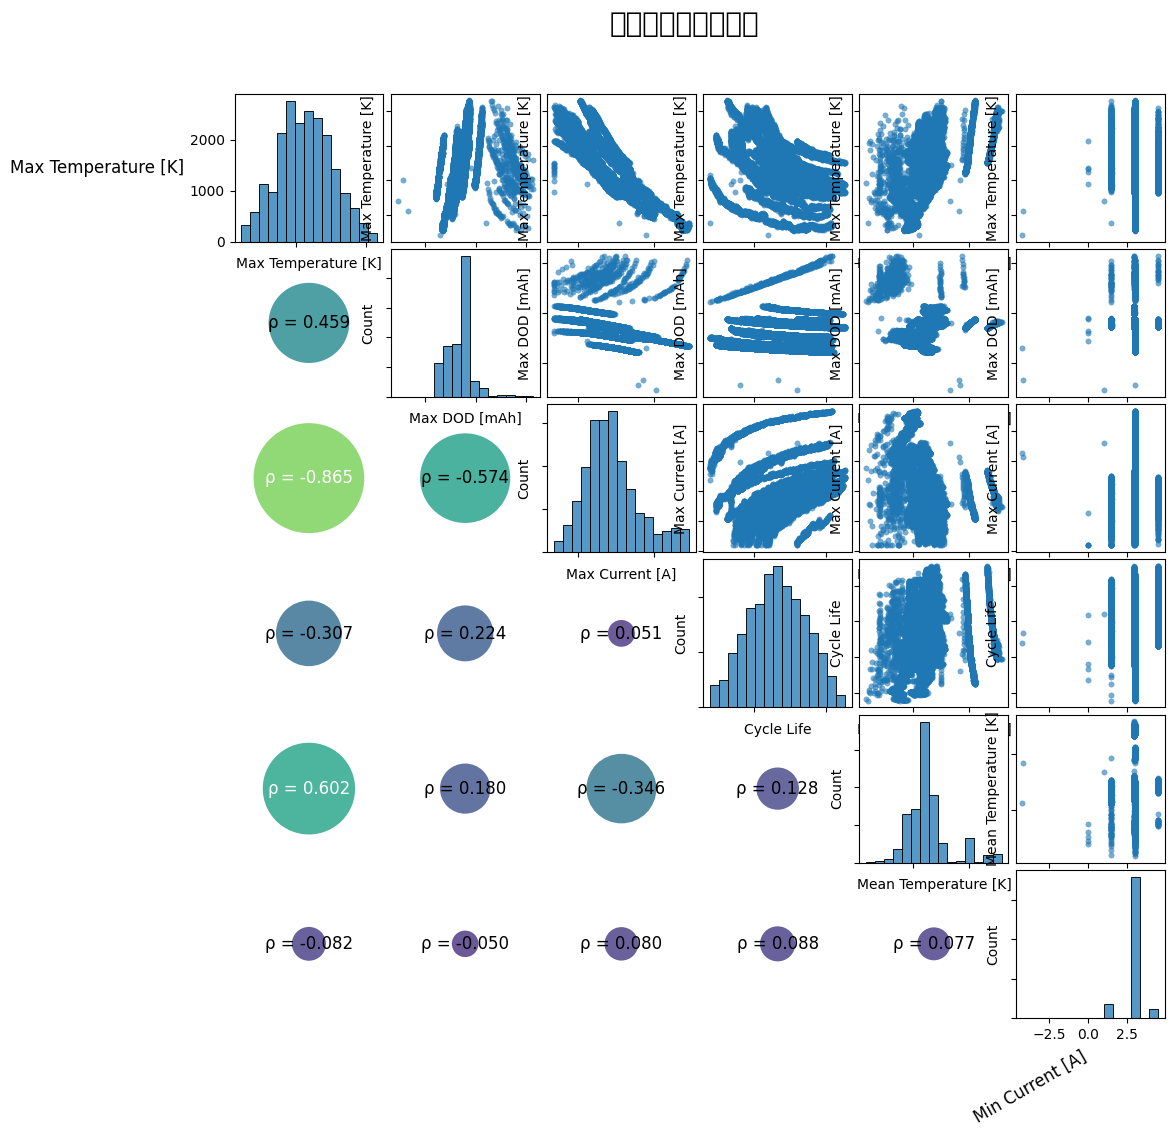

In [4]:

# 1. 从所有npz文件中提取特征
features_df = extract_features_from_all_npz(DATASET_FOLDER)

if features_df is not None and not features_df.empty:
    # 2. 定义我们想要分析和绘图的特征列
    # 顺序与示例图保持一致
    features_to_plot = [
        'Max Temperature [K]',
        'Max DOD [mAh]',
        'Max Current [A]',
        'Cycle Life',
        'Mean Temperature [K]',
        'Min Current [A]'
    ]
    
    # 3. 创建图表
    plot_correlation_matrix(features_df, features_to_plot)
else:
    print("未能提取任何特征，无法进行分析。")